In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import copy

import warnings
warnings.filterwarnings('ignore')

2024-02-19 13:03:37.004155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 13:03:37.004288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 13:03:37.157589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_set = pd.read_csv('../input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

In [3]:
# ワンホットエンコーディング
data = pd.get_dummies(data_set.loc[:, 'Type':'Tool wear [min]'], dtype='float64')

# スケール化
data.loc[:, 'Air temperature [K]':'Tool wear [min]'] = MinMaxScaler().fit_transform(data.loc[:, 'Air temperature [K]':'Tool wear [min]'])

data['Target'] = data_set['Target']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  float64
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  float64
 5   Type_H                   10000 non-null  float64
 6   Type_L                   10000 non-null  float64
 7   Type_M                   10000 non-null  float64
 8   Target                   10000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 703.2 KB


In [4]:
train, test = train_test_split(data, train_size=0.7, random_state=42)
print('0: {}'.format((train.Target == 0).sum()))
print('1: {}'.format((train.Target == 1).sum()))

0: 6754
1: 246


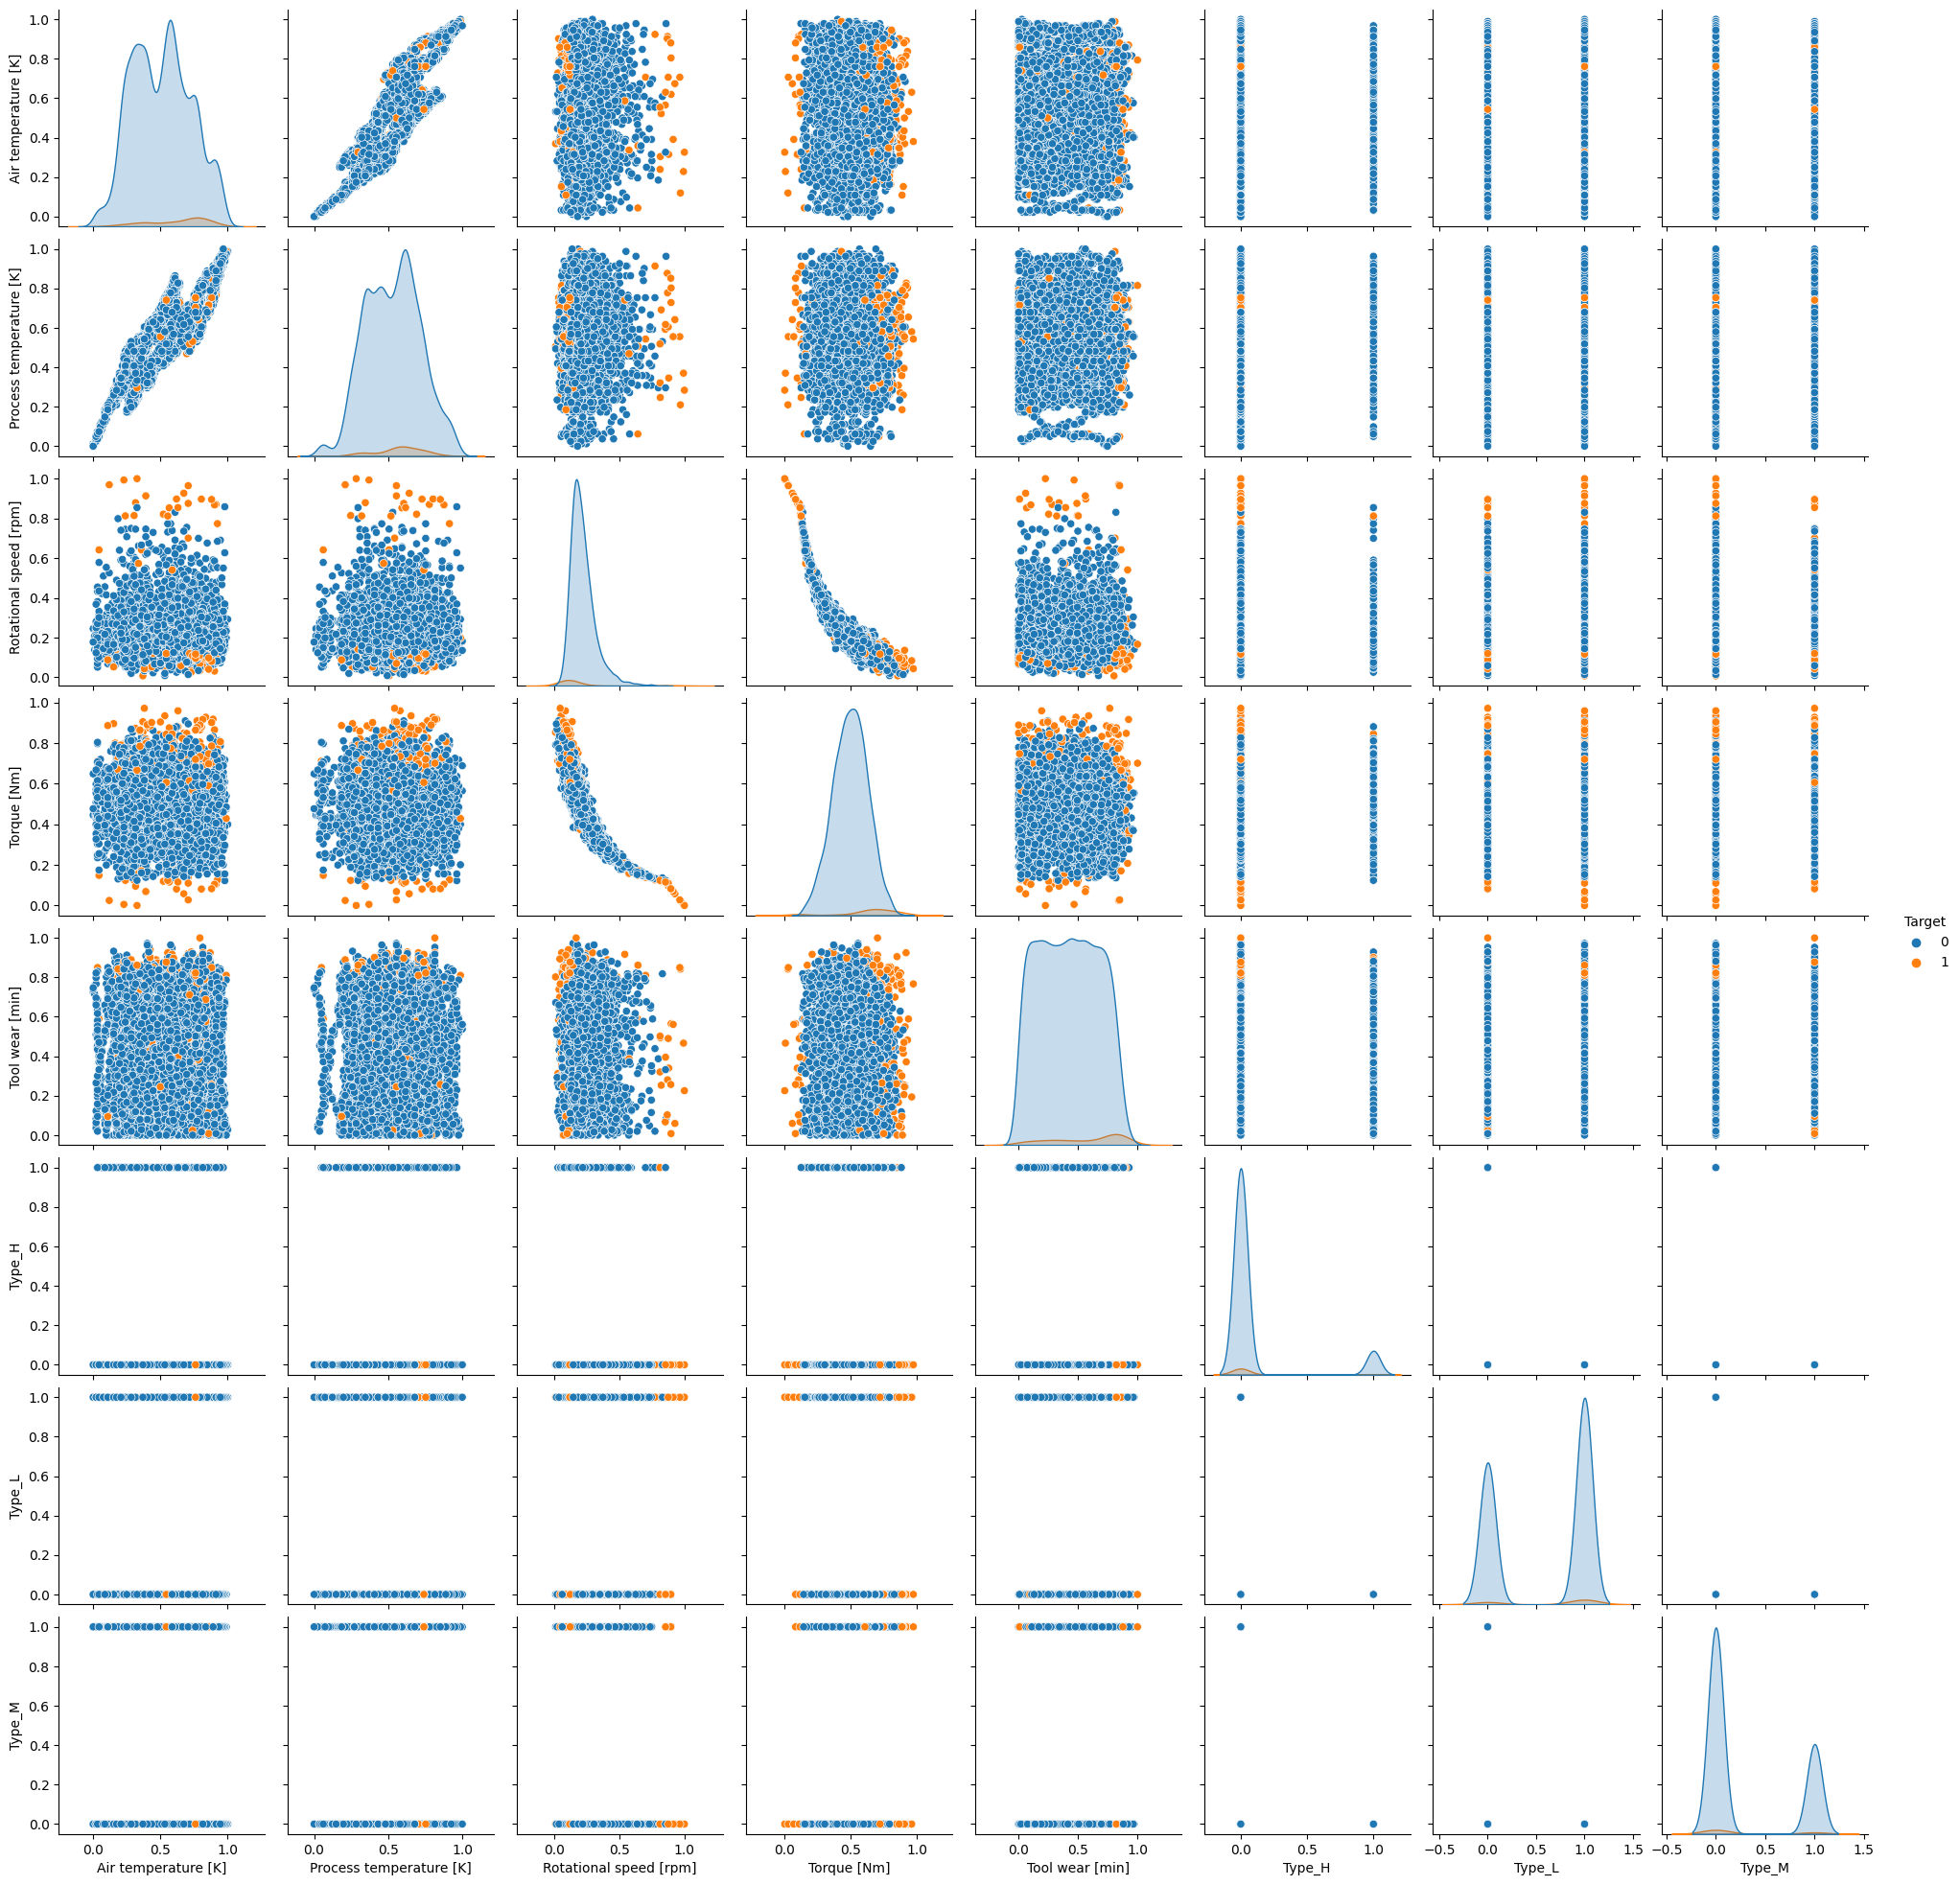

In [5]:
# ペアプロット
sns.pairplot(train, vars=train.columns[:-1], hue=train.columns[-1])

# データオーグメンテーション

In [6]:
# 同じデータを複製して増やす
duplication_train = copy.deepcopy(train)
while((duplication_train.Target == 0).sum() > (duplication_train.Target == 1).sum()):
    duplication_train = pd.concat([duplication_train, train[train.Target == 1]])
    
print('0: {}'.format((duplication_train.Target == 0).sum()))
print('1: {}'.format((duplication_train.Target == 1).sum()))

0: 6754
1: 6888


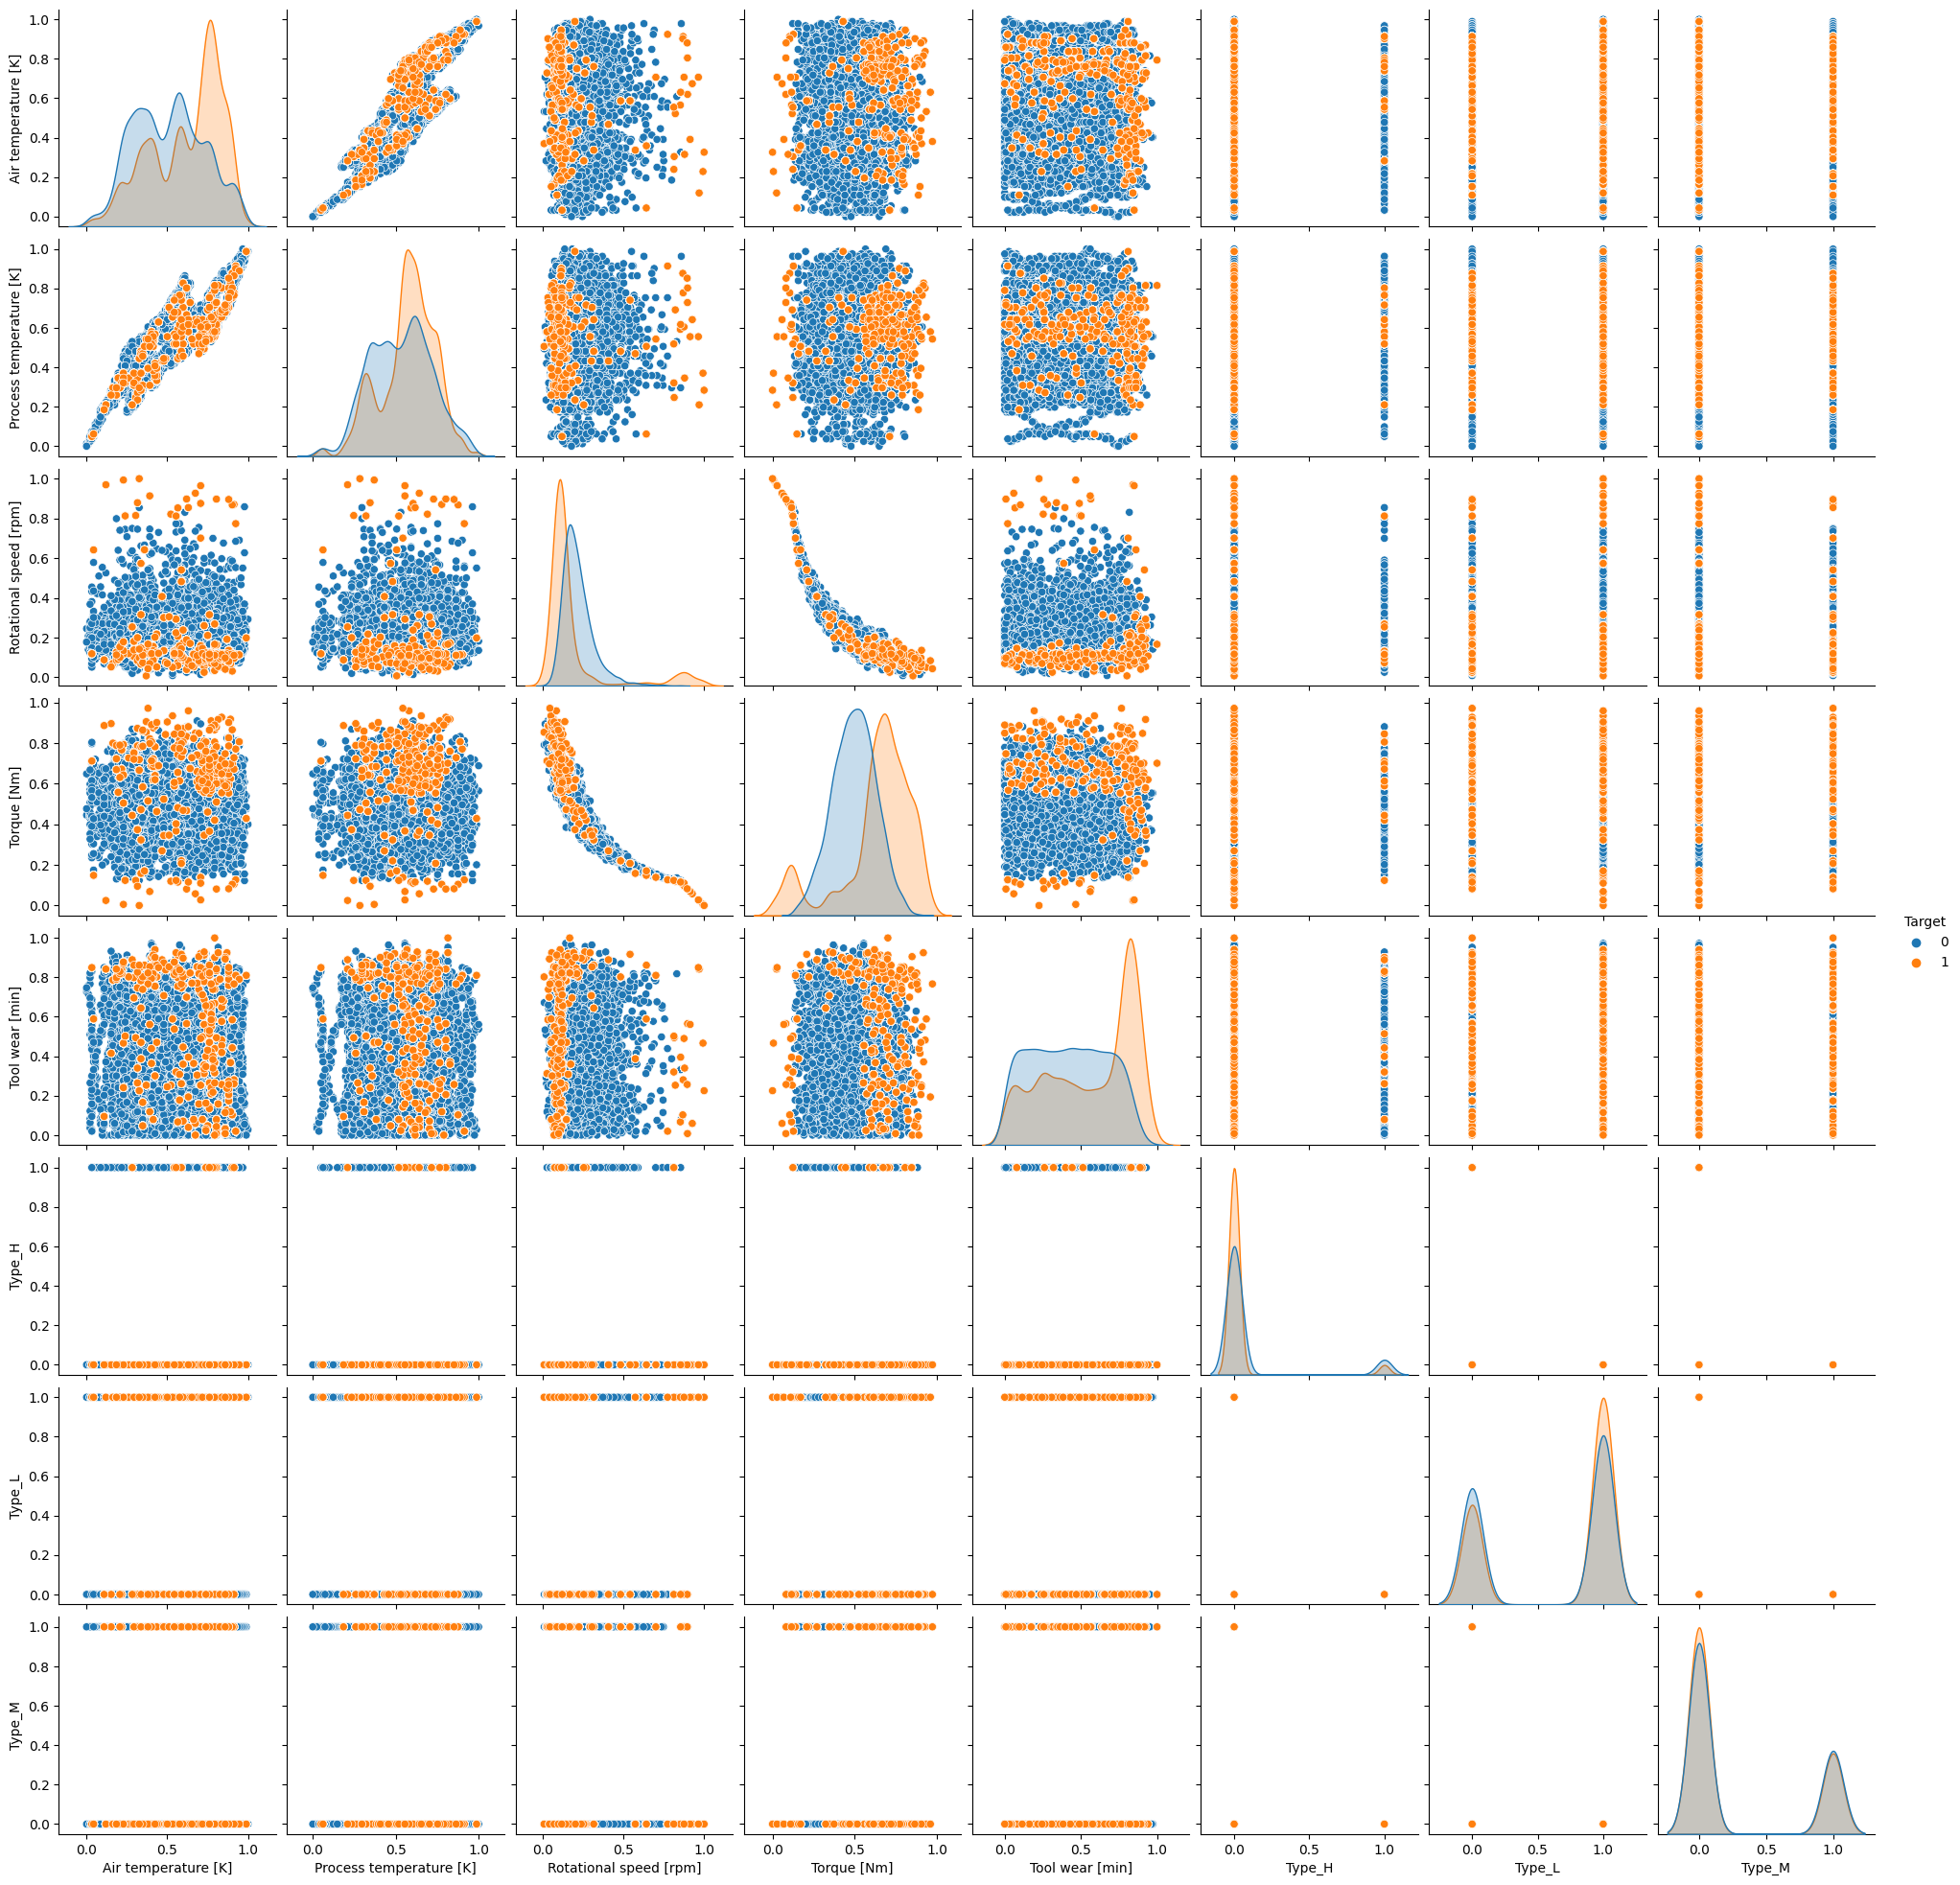

In [7]:
# ペアプロット
sns.pairplot(duplication_train, vars=duplication_train.columns[:-1], hue=duplication_train.columns[-1])

In [8]:
# オートエンコーダ定義

# モデル定義
inp = Input(shape=8)
encoded = Dense(4, activation='relu')(inp)
decoded = Dense(8, activation='relu')(encoded)

# モデルコンパイル
autoencoder = Model(inp, decoded)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy()) # 損失関数: 2値分類クロスエントロピー

# 訓練データから異常データのみを抽出
X = train[train.Target == 1].drop(['Target'], axis=1)
y = pd.DataFrame(train['Target'][train.Target == 1])

# モデル学習
autoencoder.fit(X, y, epochs=50, batch_size=8, shuffle=True)

Epoch 1/50
31/31 [==============================] - 1s 2ms/step - loss: 5.3540
Epoch 2/50
31/31 [==============================] - 0s 2ms/step - loss: 4.4911
Epoch 3/50
31/31 [==============================] - 0s 2ms/step - loss: 4.3377
Epoch 4/50
31/31 [==============================] - 0s 2ms/step - loss: 4.2402
Epoch 5/50
31/31 [==============================] - 0s 2ms/step - loss: 4.1679
Epoch 6/50
31/31 [==============================] - 0s 2ms/step - loss: 4.0975
Epoch 7/50
31/31 [==============================] - 0s 2ms/step - loss: 4.0259
Epoch 8/50
31/31 [==============================] - 0s 2ms/step - loss: 3.9769
Epoch 9/50
31/31 [==============================] - 0s 2ms/step - loss: 3.9375
Epoch 10/50
31/31 [==============================] - 0s 2ms/step - loss: 3.9083
Epoch 11/50
31/31 [==============================] - 0s 2ms/step - loss: 3.8874
Epoch 12/50
31/31 [==============================] - 0s 2ms/step - loss: 3.8723
Epoch 13/50
31/31 [==============================

In [9]:
# オートエンコーダで増やす
autoencoder_train = copy.deepcopy(train)
abnormality = train[train.Target == 1].drop(['Target'], axis=1) # 異常データのみ抽出
while((autoencoder_train.Target == 0).sum() > (autoencoder_train.Target == 1).sum()):
    decoded = pd.DataFrame(autoencoder.predict(abnormality))
    decoded['Target'] = 1
    decoded.columns = train.columns
    autoencoder_train = pd.concat([autoencoder_train, decoded])
    
print('0: {}'.format((autoencoder_train.Target == 0).sum()))
print('1: {}'.format((autoencoder_train.Target == 1).sum()))

8/8 [==============================] - 0s 2ms/step
0: 6754
1: 6888


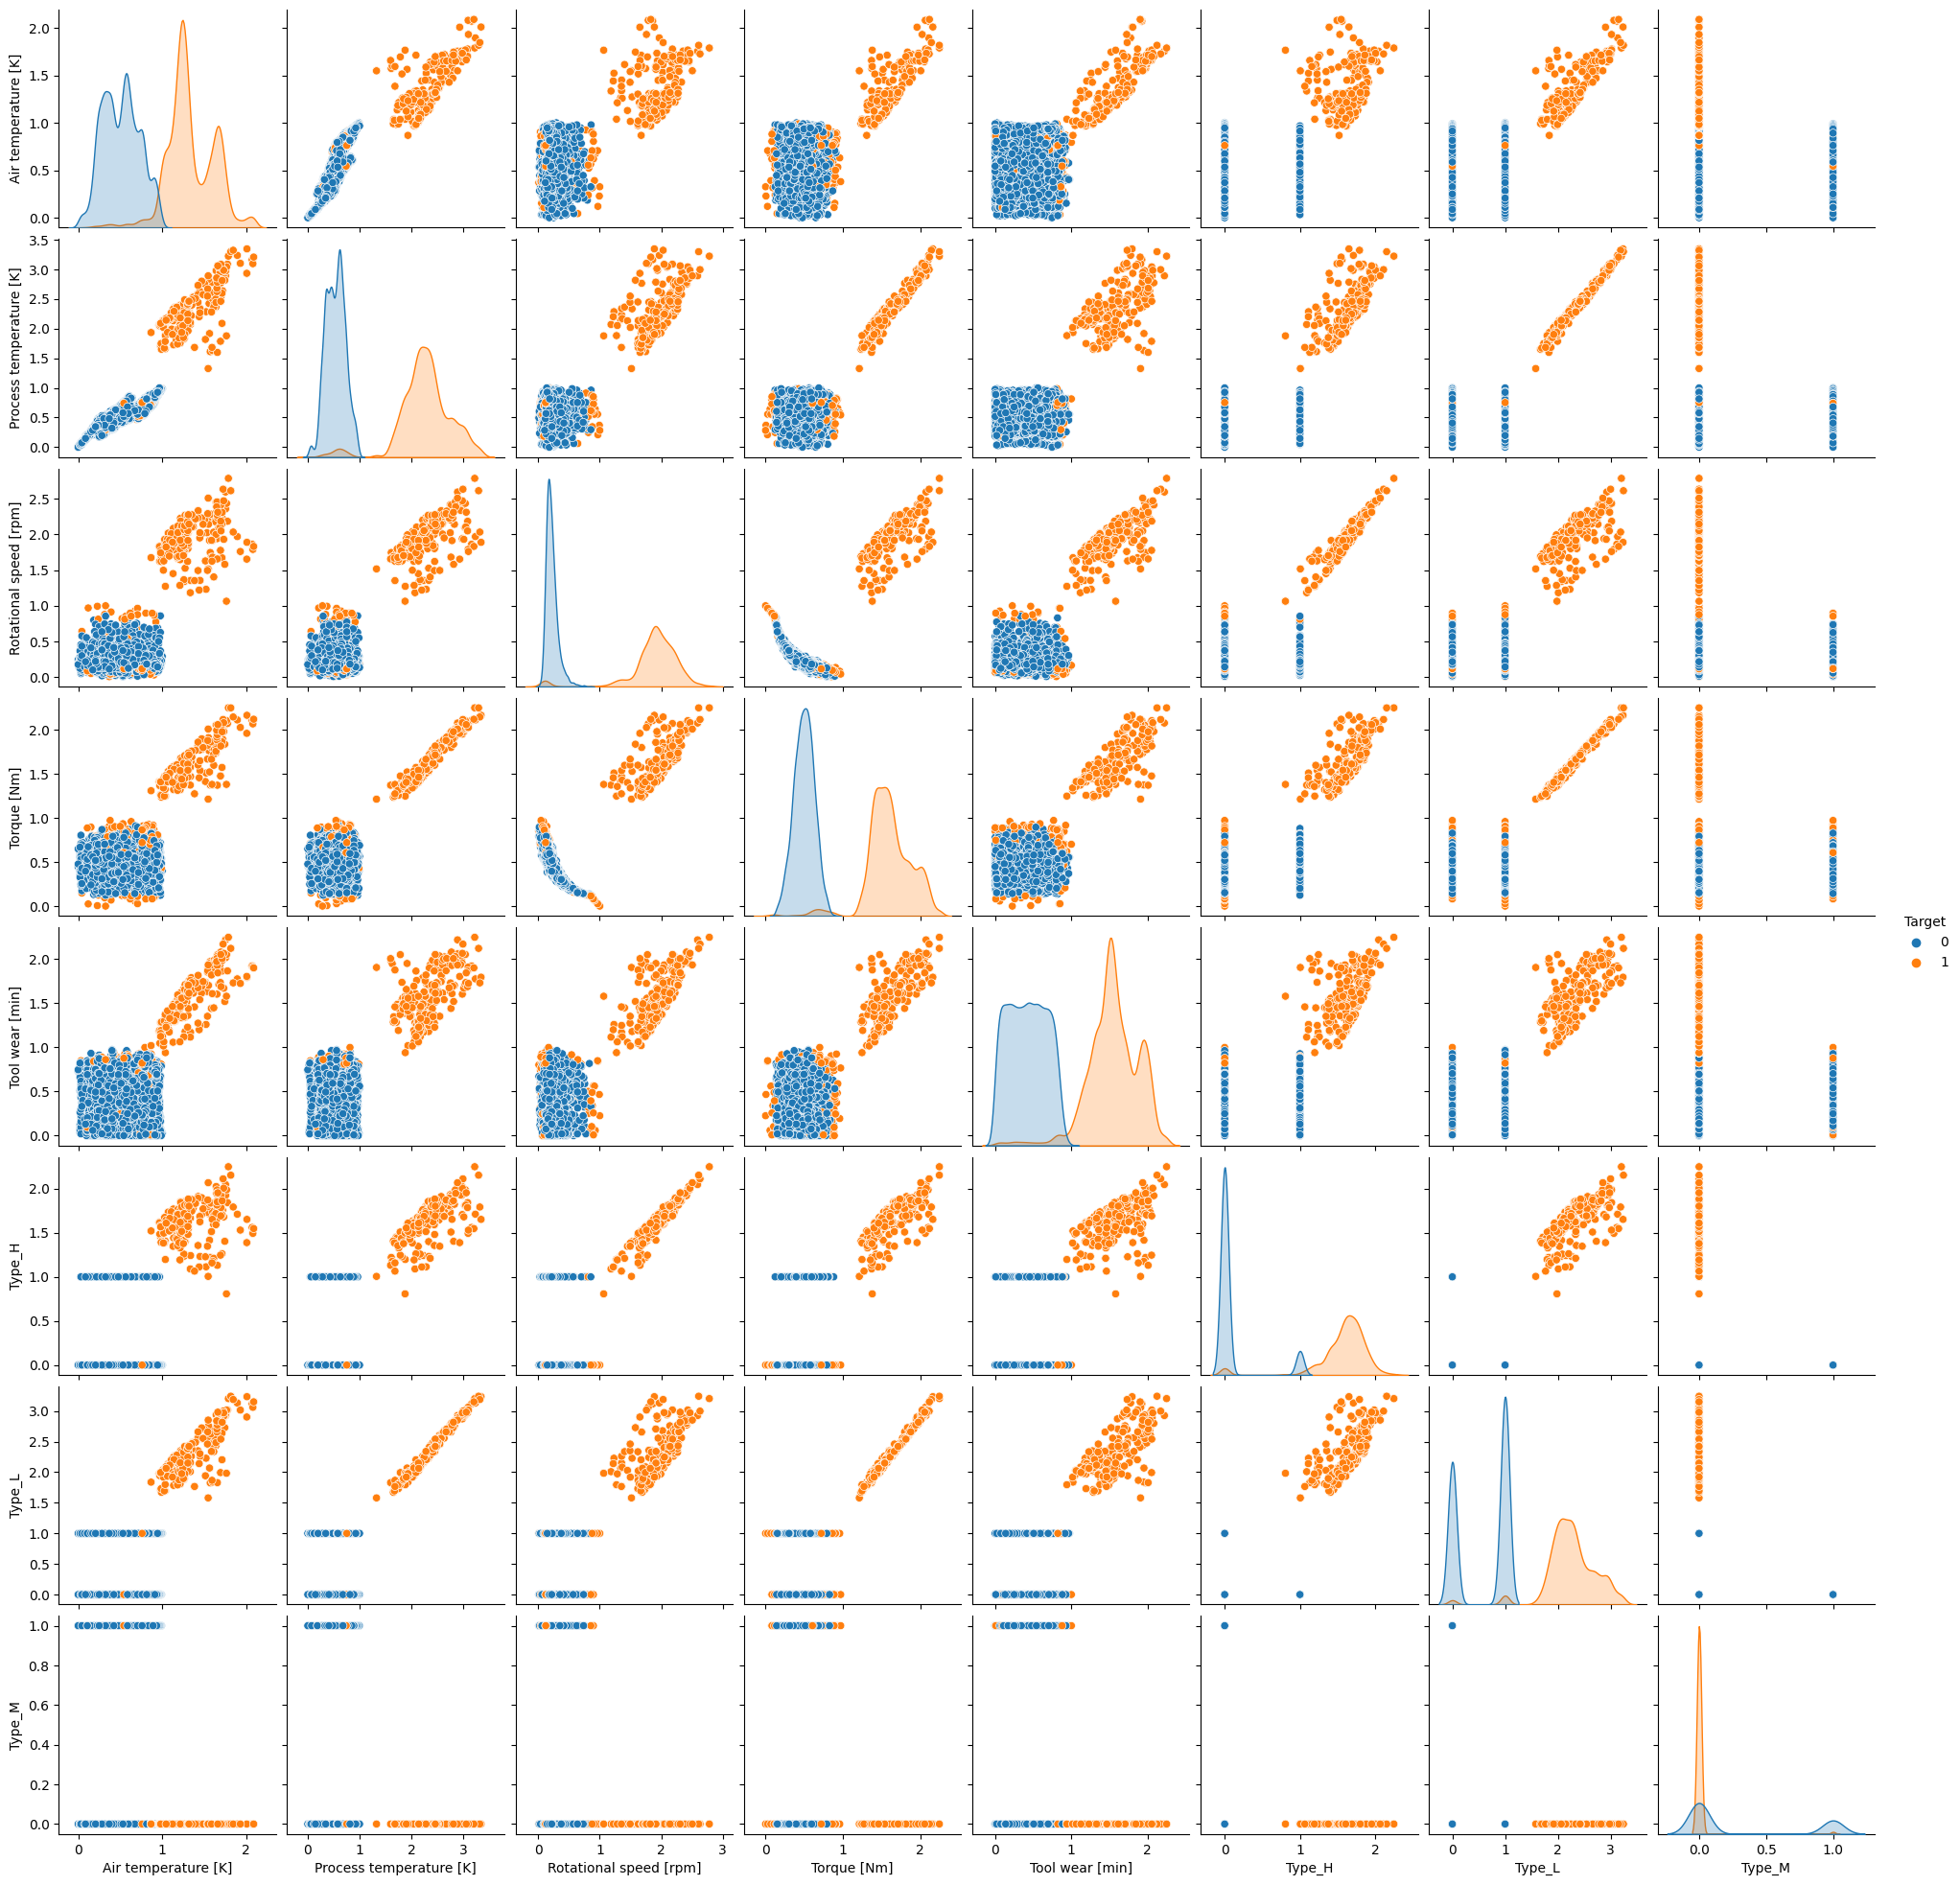

In [10]:
# ペアプロット
sns.pairplot(autoencoder_train, vars=autoencoder_train.columns[:-1], hue=autoencoder_train.columns[-1])

In [11]:
# SMOTEで増やす
sm = SMOTE(k_neighbors=5, random_state=42)
X = train.drop(columns='Target', axis=1)
y = train['Target']
X_sample, y_sample = sm.fit_resample(X, y)
smote_train = pd.concat([X_sample, y_sample], axis=1)

print('0: {}'.format((smote_train.Target == 0).sum()))
print('1: {}'.format((smote_train.Target == 1).sum()))

0: 6754
1: 6754


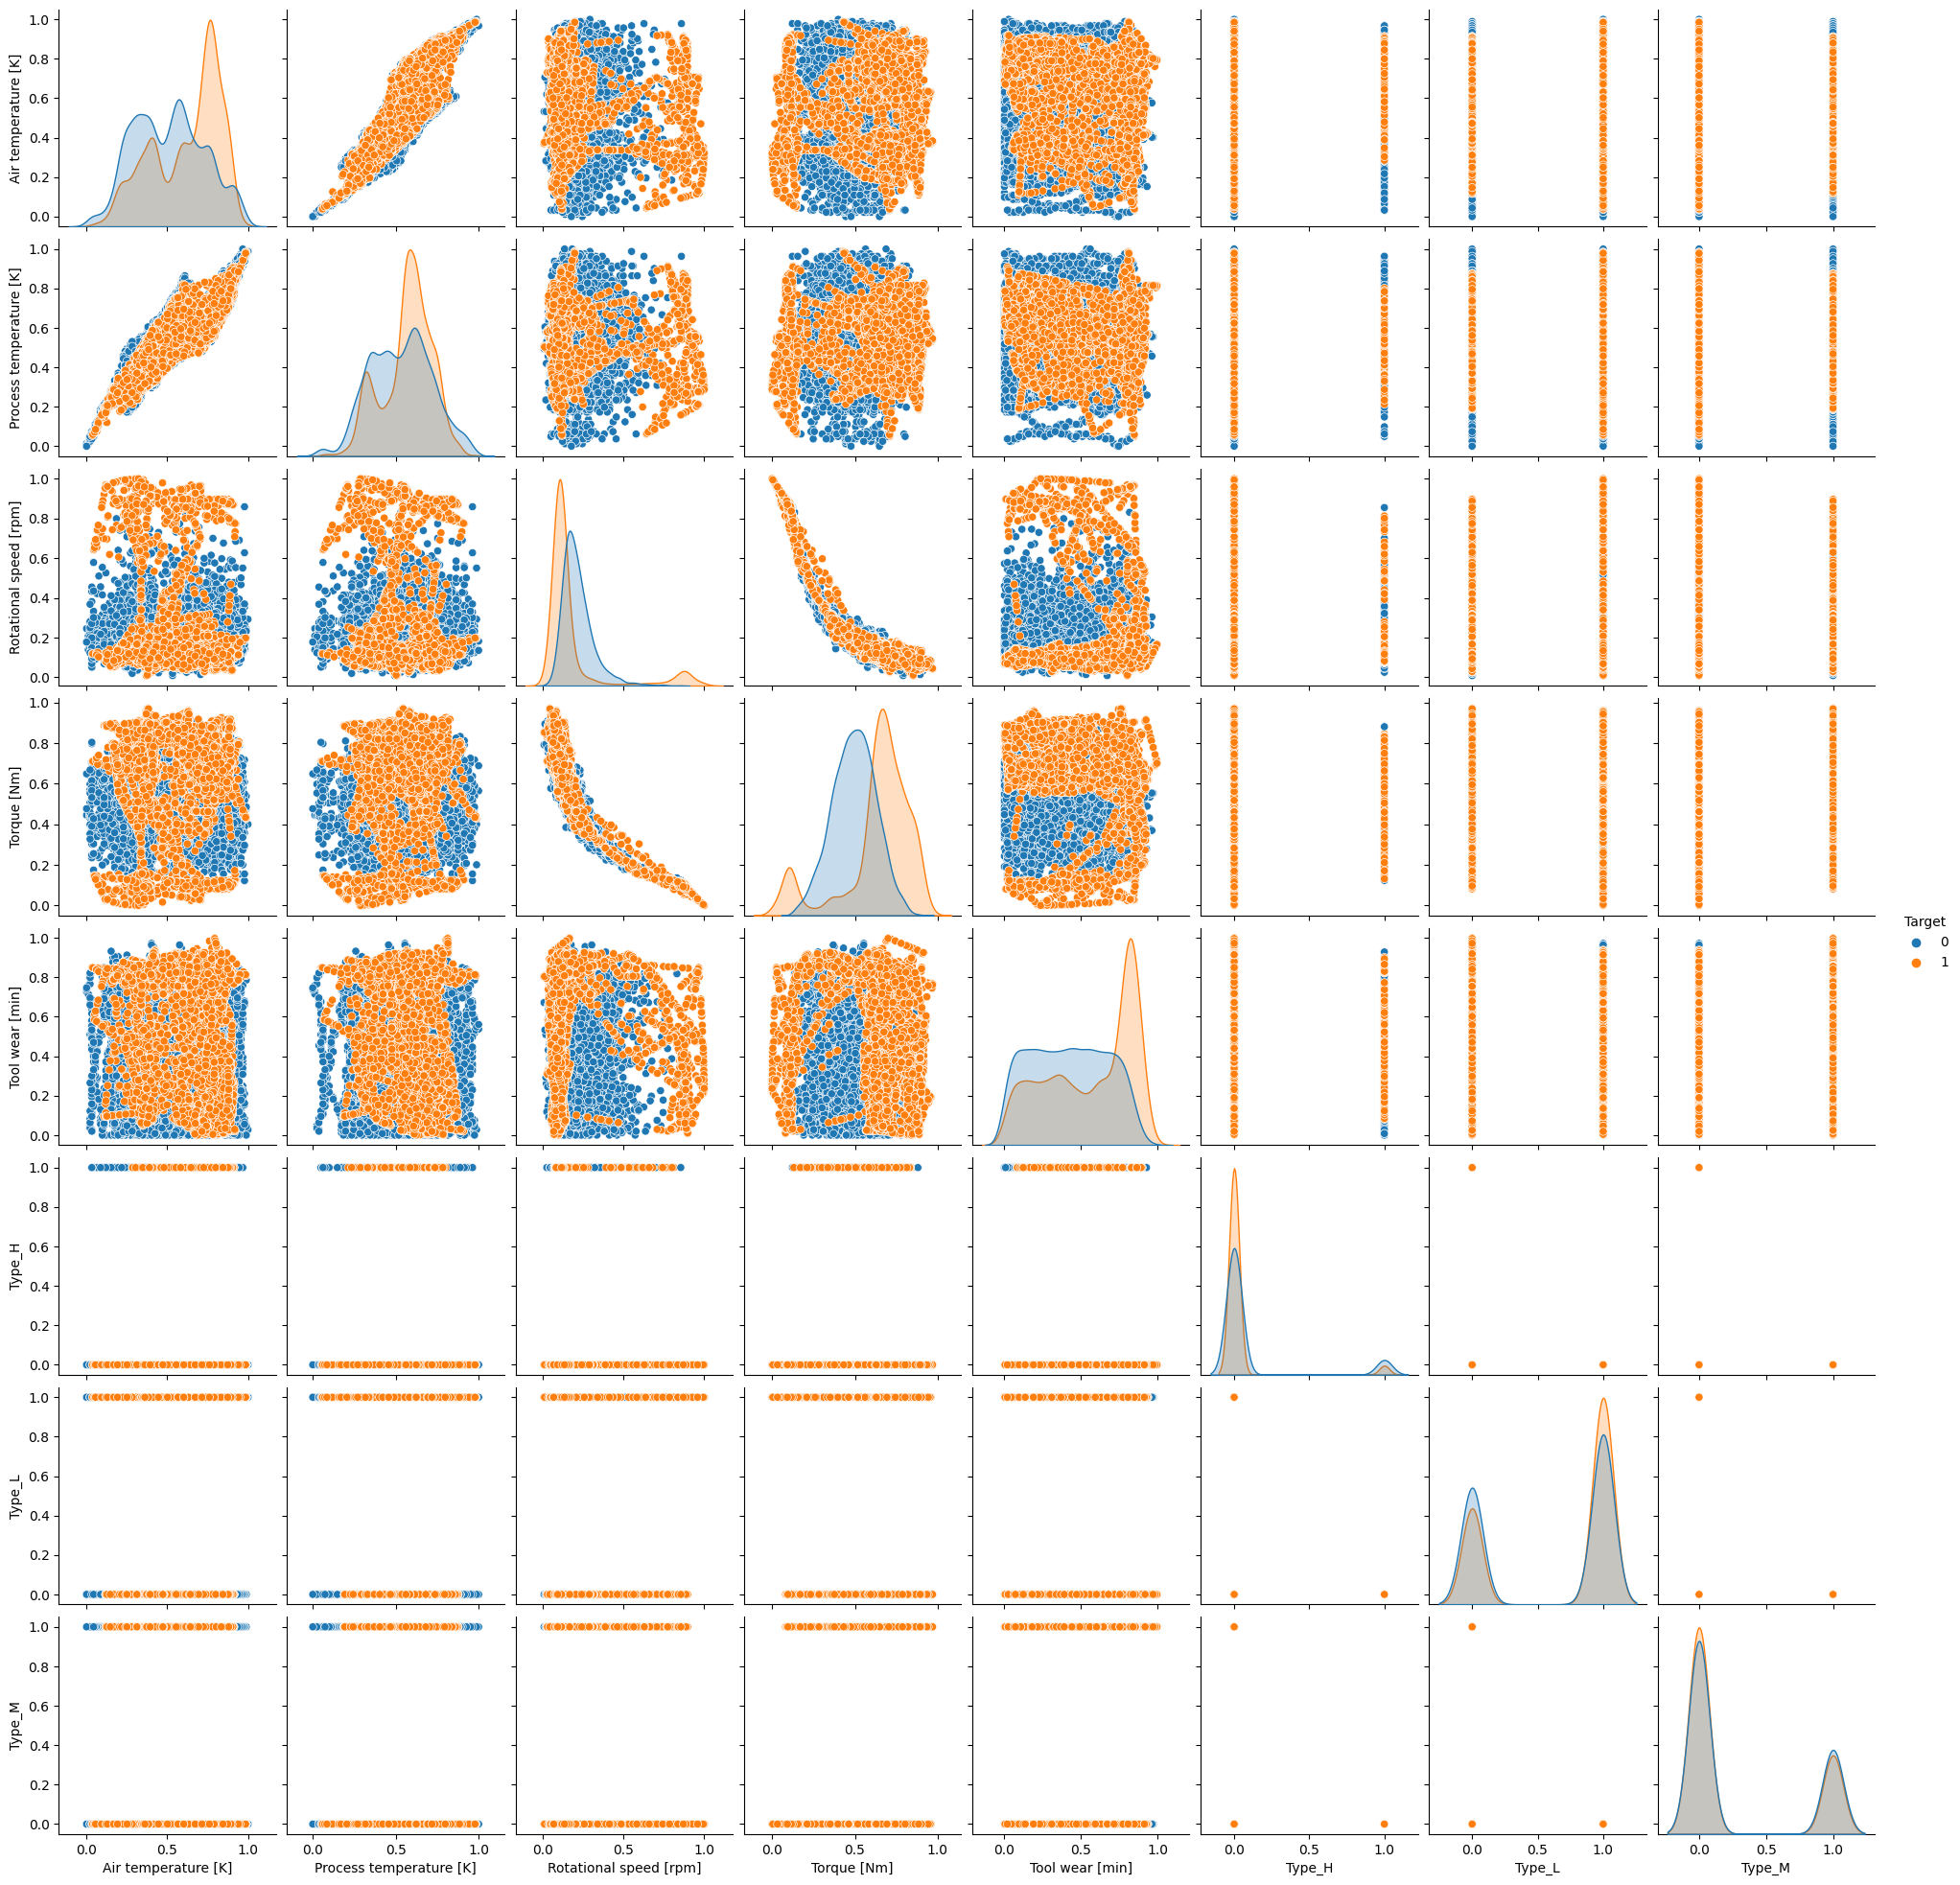

In [12]:
# ペアプロット
sns.pairplot(smote_train, vars=smote_train.columns[:-1], hue=smote_train.columns[-1])

# 予測

In [13]:
# パイプライン
pipe = Pipeline([('classify', RandomForestClassifier(random_state=10, max_features='sqrt'))])
param_test = {'classify__n_estimators': list(range(13, 15, 1)),
              'classify__max_depth': list(range(5, 9, 1))}

# グリッドサーチ
grid = GridSearchCV(estimator=pipe, param_grid=param_test, scoring='recall', cv=10)

In [14]:
# 予測結果

train_dict = {'duplication_train': duplication_train,
              'autoencoder_train': autoencoder_train,
              'smote_train': smote_train
             }

X_test = test.drop(columns='Target', axis=1)
y_test = test['Target']

for name, tr in train_dict.items():
    X_train = tr.drop(columns='Target', axis=1)
    y_train = tr['Target']
    grid.fit(X_train, y_train)
    predict = grid.predict(X_test)
    print('{}:'.format(name))
    print('best_params_: {}\nbest_score_: {:.3f}'.format(grid.best_params_, grid.best_score_))
    print('test_score_: {:.3f}'.format(recall_score(y_test, predict)))
    print()

duplication_train:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 13}
best_score_: 0.987
test_score_: 0.710

autoencoder_train:
best_params_: {'classify__max_depth': 5, 'classify__n_estimators': 13}
best_score_: 0.964
test_score_: 0.108

smote_train:
best_params_: {'classify__max_depth': 8, 'classify__n_estimators': 14}
best_score_: 0.962
test_score_: 0.806



# 考察

In [15]:
"""
・元データの複製でも、過学習が発生しているもののある程度高い再現率が得られた
・オートエンコーダについて、異常データの再構築がうまくいかない
　理由として挙げられるもの → データ数の少なさ(246), データが偏っている(恐らく×), アルゴリズムや損失関数が最適でない
　活性化関数/損失関数/エポック数/バッチサイズを変えて試してみたが、うまくいかなかった
・前回の処理内容(正常データを大量にオートエンコーダに読み込み、誤差により異常を検出)では平均二乗誤差を用いたが、2値分類にも関わらずうまくいったのは何故?
"""

'\n・元データの複製でも、過学習が発生しているもののある程度高い再現率が得られた\n・オートエンコーダについて、異常データの再構築がうまくいかない\n\u3000理由として挙げられるもの → データ数の少なさ(246), データが偏っている(恐らく×), アルゴリズムや損失関数が最適でない\n\u3000活性化関数/損失関数/エポック数/バッチサイズを変えて試してみたが、うまくいかなかった\n・前回の処理内容(正常データを大量にオートエンコーダに読み込み、誤差により異常を検出)では平均二乗誤差を用いたが、2値分類にも関わらずうまくいったのは何故?\n'